In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import Counter
from sklearn import linear_model, datasets
from skimage.measure import LineModelND, ransac
import math


In [6]:
def findgreen(image):
    thres = 63
    # find sample methods
    ys = np.random.choice(np.linspace(200,479,278),100)
    xs = np.random.choice(np.linspace(0,600,601),100)
    
    values = [image[int(ys[i]),int(xs[i])] for i in range(100)]
    countVal = Counter(values)
    modus = countVal.most_common(1)[0][0]

    # optie om via arrays sneller te maken
    minmod = np.array(np.array(modus) - thres)
    maxmod = np.array(np.array(modus) + thres)
    
#     return image[image<maxmod and image>minmod]
    nimage = image[:].copy()
    
    # Via opencv
    nimage = cv2.inRange(image,minmod,maxmod)
    
    return nimage

In [111]:
def getField(img):
    blur =cv2.GaussianBlur(img,(71,71),10)
    hsv =  cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    greenFiltered = findgreen(np.array(s))
    edge = cv2.Canny(greenFiltered, 20,40)
    ransac = linear_model.RANSACRegressor()
    y,x = np.argwhere(edge == 255)[:,0], np.argwhere(edge == 255)[:,1]

    
    #preprocess:
    bot_mask = y < 400
    xp = x[bot_mask]
    yp = y[bot_mask]
    data = np.array([xp,yp]).T
    
    #
    from skimage.measure import LineModelND, ransac
    model_robust, inliers_mask = ransac(data, LineModelND, min_samples=2, residual_threshold=1, max_trials=300)
    outliers_mask = inliers_mask == False

    yin = data.T[1][inliers_mask]
    xin = data.T[0][inliers_mask]
    plt.imshow(edge)
    plt.plot(xin,yin, "r.")
#     plt.show()
    
    # from points get line:
    Ny,Nx = np.shape(edge)
    xdiff = xin[0] - xin[-1]
    ydiff = yin[0] - yin[-1]
    if xdiff == 0 or ydiff == 0:
        # in case line is horizontal or vertical
        exit()
    a = ydiff/xdiff
    b = yin[0] - xin[0]*a
    line = a*np.arange(Nx) + b
    plt.plot(line)

    # Do same for second line:
    data2 = data[outliers_mask]
    model_robust, inliers_mask = ransac(data2, LineModelND, min_samples=2, residual_threshold=1, max_trials=300)
    yin = data2.T[1][inliers_mask]
    xin = data2.T[0][inliers_mask]
    plt.plot(xin,yin, "g.")

    # from points get line:
    Ny,Nx = np.shape(edge)
    xdiff = xin[0] - xin[-1]
    ydiff = yin[0] - yin[-1]
    if xdiff == 0 or ydiff == 0:
        # in case line is horizontal or vertical
        exit()
    a = ydiff/xdiff
    b = yin[0] - xin[0]*a
    line2 = a*np.arange(Nx) + b
    plt.plot(line2)
    plt.show()
    p0, angle = get_angle([[0,line[0]],[Nx, line[-1]]], [[0,line2[0]],[Nx, line2[-1]]] )
    print(angle)
    if p0 == False or p0[0] < 0 or p0[0]> Ny or p0[1] < 0 or p0[1] > Nx or abs(angle) <1:
        # no second line
        print("No Second line:")
        line2 == [0,0]
    
    # Area enclosed by first line
    # Polygon coordinates [[top left], [top right], [bottom right], [bottom left]]
    area1 = np.array([[[0,0],[Nx,0],[Nx,line[-1]],[0, line[0]]]], dtype=np.int32)
    # ... second line
    
    area2 = np.array( [[[0,0],[Nx,0],[Nx,line2[-1]],[0, line2[0]]]], dtype=np.int32 )
    cv2.fillPoly(edge, area1, 255)
    cv2.fillPoly(edge, area2, 255)

    # Using tilde (~) to fill in either the field or the non-field part
    plt.subplot(121), plt.imshow(~edge, cmap='Greys_r')

    plt.imshow(img)
    plt.figure()
    original_copy = img
    cv2.fillPoly(original_copy, area1, 0)
    cv2.fillPoly(original_copy, area2, 0)
    plt.subplot(122), plt.imshow(original_copy)

    plt.show()


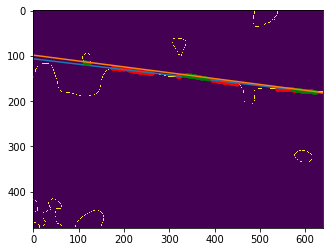

(751.1356748083448, 195.43037974683554)
0.6088945765998997
No Second line:


/home/leonardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


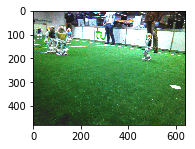

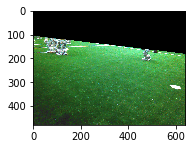

In [114]:
img = cv2.imread("testField1.png")
getField(img)

# Komt nog:

In [84]:
from __future__ import division 
def get_angle(points1,points2):
        p1 = points1[0]
        p2 = points2[0]
        L1 = line(p1, points1[1])
        L2 = line(p2, points2[1])
        
        p0 = intersection(L1,L2)
        if p0 == False:
            return False,False
#         plt.plot(p0,"bx")
        print(p0)
        v0 = np.array(p1) - np.array(p0)
        v1 = np.array(p2) - np.array(p0)

        angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        return p0, np.degrees(angle)
              
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False
    
# L1 = line([0,0], [1,0])
# L2 = line([0,0], [0,1])

# R = intersection(L1, L2)
# R = get_angle(R,[1,0],[0,2])
# if R:
#     print("Intersection detected:", R)
# else:
#     print( "No single intersection point detected")